**Мета роботи**: Ознайомитись з використанням перетворювачів у spaCy, а також інших попередньо навчених перетворювачів. Застосувати перетворювачі для генерації діалогів.
Створити програму, що налаштовує попередньо навчені перетворювачі та використовує їх для генерації діалогів

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import random

from torch.utils.data import DataLoader, TensorDataset
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

Створення навчальних даних

In [4]:
filename = r'C:\Users\5500\DataspellProjects\UniProjects\data\hotels.json'
with open(filename, "r", encoding="utf-8") as f:
    raw_data = json.load(f)

data = []

for dialog in raw_data:
    turns = dialog["turns"]
    for i in range(len(turns) - 1):
        user_turn = turns[i]
        system_turn = turns[i + 1]

        if user_turn["speaker"] == "USER" and system_turn["speaker"] == "SYSTEM":
            data.append((user_turn["utterance"], system_turn["utterance"]))

data = [pair for pair in data if  len(pair)==2]

In [5]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)

In [6]:
train_data[:3]

[("I'm searching for a hotel in NYC, and I'd like to reserve a room at Rodeway Inn Bronx Zoo.",
  'How long is the booking for?'),
 ('Thanks.', 'Do you need help with anything else?'),
 ('Could you tell me the phone number?',
  'The telephone number is +1 416-663-9500.')]

Токенізація і перетворення у тензори

In [7]:
input_ids = []
attention_masks = []
labels = []

for user_input, system_response in train_data:
    encoded_input = tokenizer(user_input, return_tensors="pt", padding="max_length", truncation=True, max_length=64)
    encoded_output = tokenizer(system_response, return_tensors="pt", padding="max_length", truncation=True, max_length=64)

    input_ids.append(encoded_input["input_ids"].squeeze())
    attention_masks.append(encoded_input["attention_mask"].squeeze())
    labels.append(encoded_output["input_ids"].squeeze())

input_ids = torch.stack(input_ids)
attention_masks = torch.stack(attention_masks)
labels = torch.stack(labels)


Оптимізатор і функція втрат

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

Формування датасету та батчів

In [9]:
dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Тренування моделі

In [10]:
loss_history = []
epochs = 10
total_frames = len(dataloader) * epochs
model.train()
with tqdm(total=total_frames, desc="Навчання") as pbar:

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            b_input_ids, b_attention_mask, b_labels = batch
    
            outputs = model(input_ids=b_input_ids,
                            attention_mask=b_attention_mask,
                            labels=b_labels)
    
            loss = outputs.loss
            total_loss += loss.item()
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.update(1)

        loss_history.append(total_loss)


Навчання: 100%|██████████| 970/970 [1:11:01<00:00,  4.39s/it]


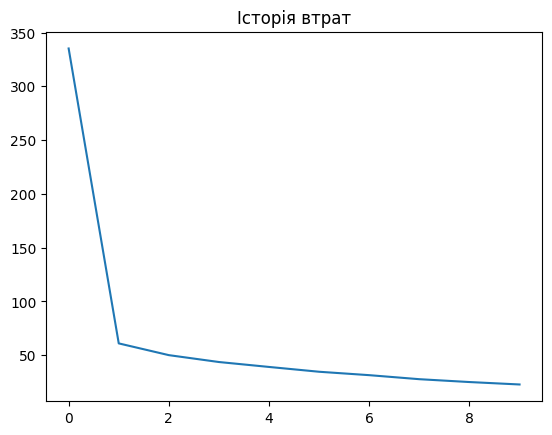

In [11]:
plt.plot(loss_history)
plt.title("Історія втрат")
plt.show()

Демонстрація роботи на випадковій фразі з тестувального набору

In [13]:
def generate_response(input_text):
    model.eval()
    encoded_input = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=64)
    output = model.generate(
        input_ids=encoded_input["input_ids"],
        attention_mask=encoded_input["attention_mask"],
        max_length=50,
        num_beams=5,
        early_stopping=True
    )
    return tokenizer.decode(output[0], skip_special_tokens=True)

example = random.choice(test_data)
print(f"Request: {example[0]}")
print(f"Response: {example[1]}")
print(f"Generated response: {generate_response(example[0])}")


Request: That's perfect.
Response: Would you like to make a reservation?
Generated response: Would you like me to reserve a room for you?
